In [2]:
print('Learning Best Practices\n'
      'for Model Evaluation and\n'
      'Hyperparameter Tuning')

Learning Best Practices
for Model Evaluation and
Hyperparameter Tuning


In [3]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
                 header=None)

In [13]:
from sklearn.preprocessing import LabelEncoder
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
X.shape

(569, 30)

In [20]:
le.classes_

array(['B', 'M'], dtype=object)

In [24]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


In [29]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold
kfold = StratifiedKFold(y=y_train, n_folds=10, random_state=1)
scores = []

for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [36]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


In [37]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(pipe_lr, X_train, y=y_train, cv=10, n_jobs=1)
print('CV accuracy: %s' % scores)

CV accuracy: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]


In [38]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


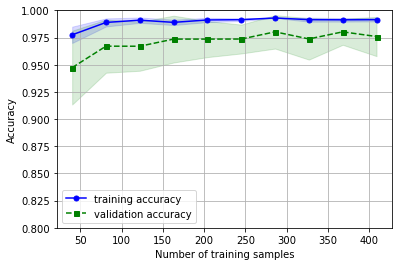

In [43]:
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', random_state=0))])
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, linestyle='--', label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.ylim([0.8, 1.0])
plt.show()

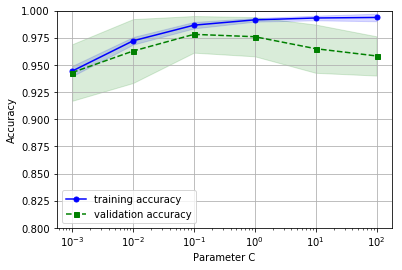

In [46]:
from sklearn.learning_curve import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name='clf__C', param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', marker='s', markersize=5, linestyle='--', label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.ylim([0.8, 1.0])
plt.show()

In [52]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(random_state=1))])
param_range = [10**k for k in range(-4, 4)]
param_grid = [{'clf__C': param_range,
               'clf__kernel': ['linear']},
              {'clf__C': param_range,
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.978021978021978
{'clf__kernel': 'linear', 'clf__C': 0.1}


In [54]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965
